In [7]:
pip install gymnasium


DEPRECATION: Loading egg at /Users/apple/ilgc/lib/python3.11/site-packages/pyrvo2-0.0.0-py3.11-macosx-11.1-arm64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
#custom files
import gridworld_converter
import robo_nav_algo as robo
import free_space_finder
import utils
import obstacle_generator as obs
import baseline_robo_nav as baseline



#standard files
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env


# Preparation of the grid world

<IPython.core.display.Javascript object>


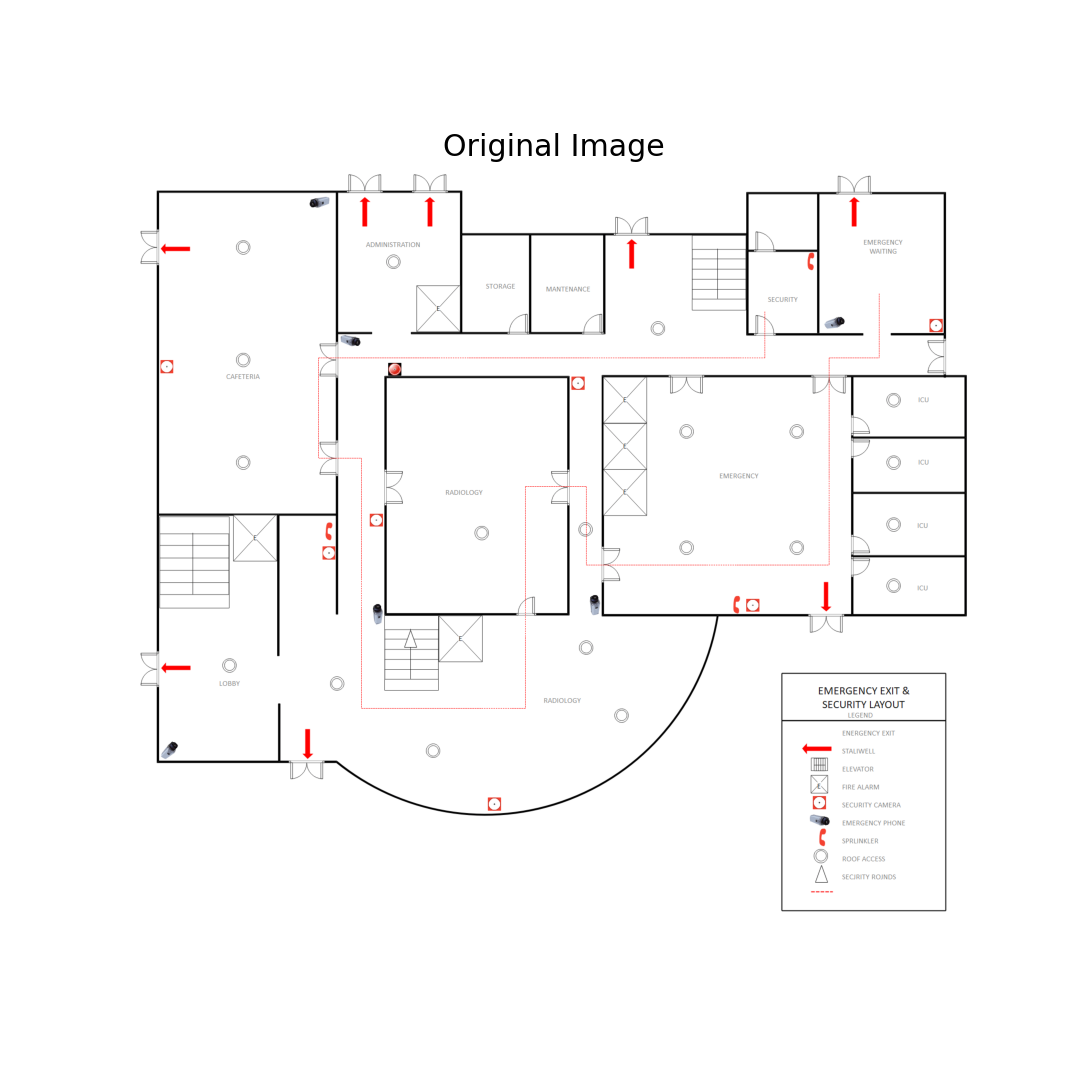

In [22]:
# Load the Image
image = cv2.imread('example6.png', cv2.IMREAD_COLOR)

utils.display_image('Original Image', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

<IPython.core.display.Javascript object>


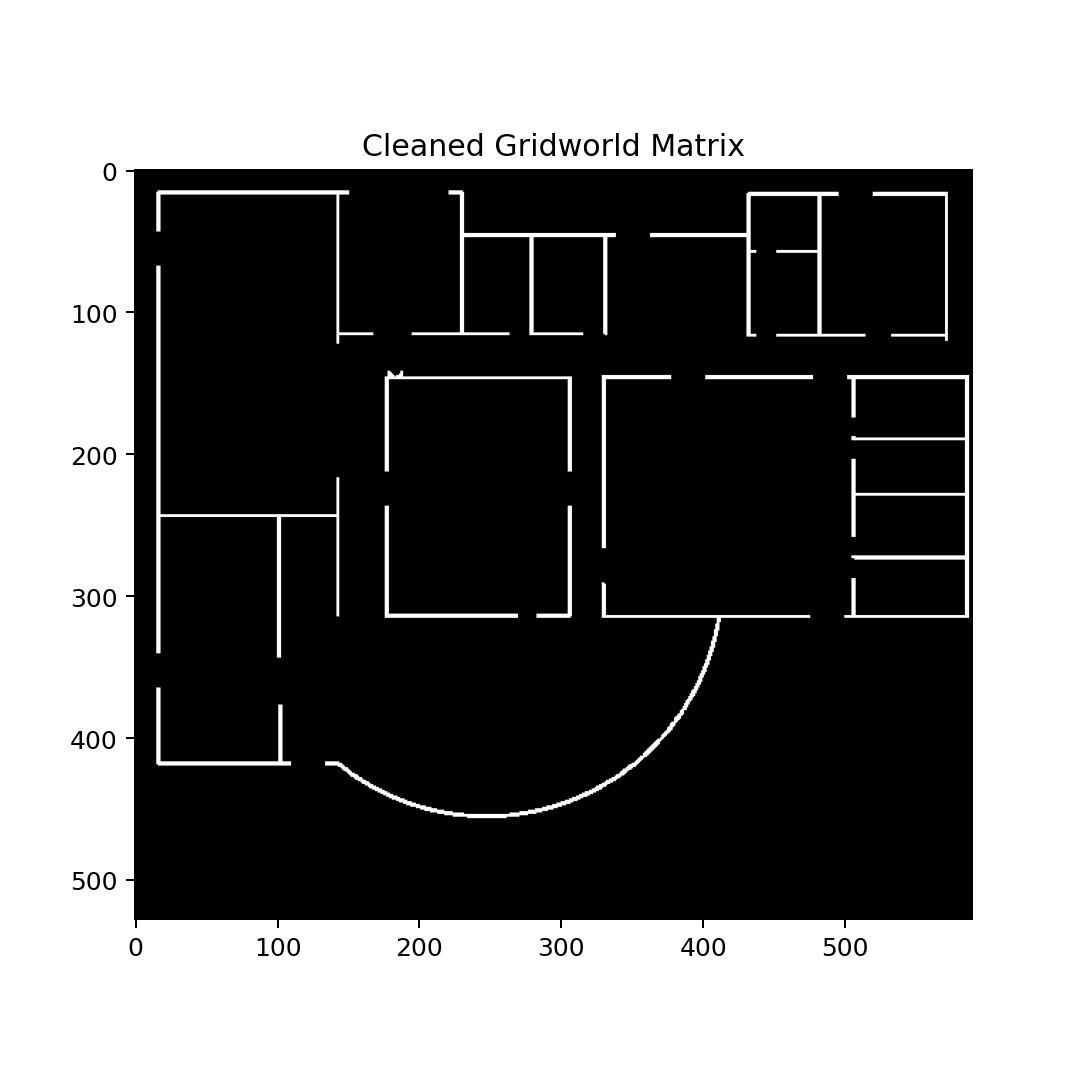

Number of rows: 528
Number of columns: 590


In [23]:
# 2d matrix representation of the above blueprint
# value of scale can be used to control how much you want to zoom into the grid world
gridworld = gridworld_converter.grid_convert('example6.png',scale = 3)
utils.display_image('Cleaned Gridworld Matrix', gridworld, cmap='gray', axis_switch = 'on')

print(f"Number of rows: {gridworld.shape[0]}\nNumber of columns: {gridworld.shape[1]}")

# Define Parameters

In [24]:
number_of_obstacles = 2
episode_length = 500
total_timesteps = 100000  # Total training steps

# Dynamic Obstacle Generator

In [25]:

# Initialize the pathfinding class
pathfinder = obs.Pathfinding(gridworld)

# Generate paths for obstacles
obstacle_paths = pathfinder.generate_paths(number_of_obstacles, episode_length)

#contains a dictionary of occupied coordinate as keys at different time step as value
'only one object can occupy a coordinate at a particular time stamp'
occupied_time_steps = pathfinder.occupied_time_steps

#contains a list of start or end coordinates of each dynamic obstacle
obstacle_occupied_points = pathfinder.obstacle_occupied_points
'''
Help:
You can see the obstacle path by obstacle_paths['1'] or obstacle_paths['2']
'''

"\nHelp:\nYou can see the obstacle path by obstacle_paths['1'] or obstacle_paths['2']\n"


# EXTRA CODE:
visualisation code for only obstacles path


<IPython.core.display.Javascript object>


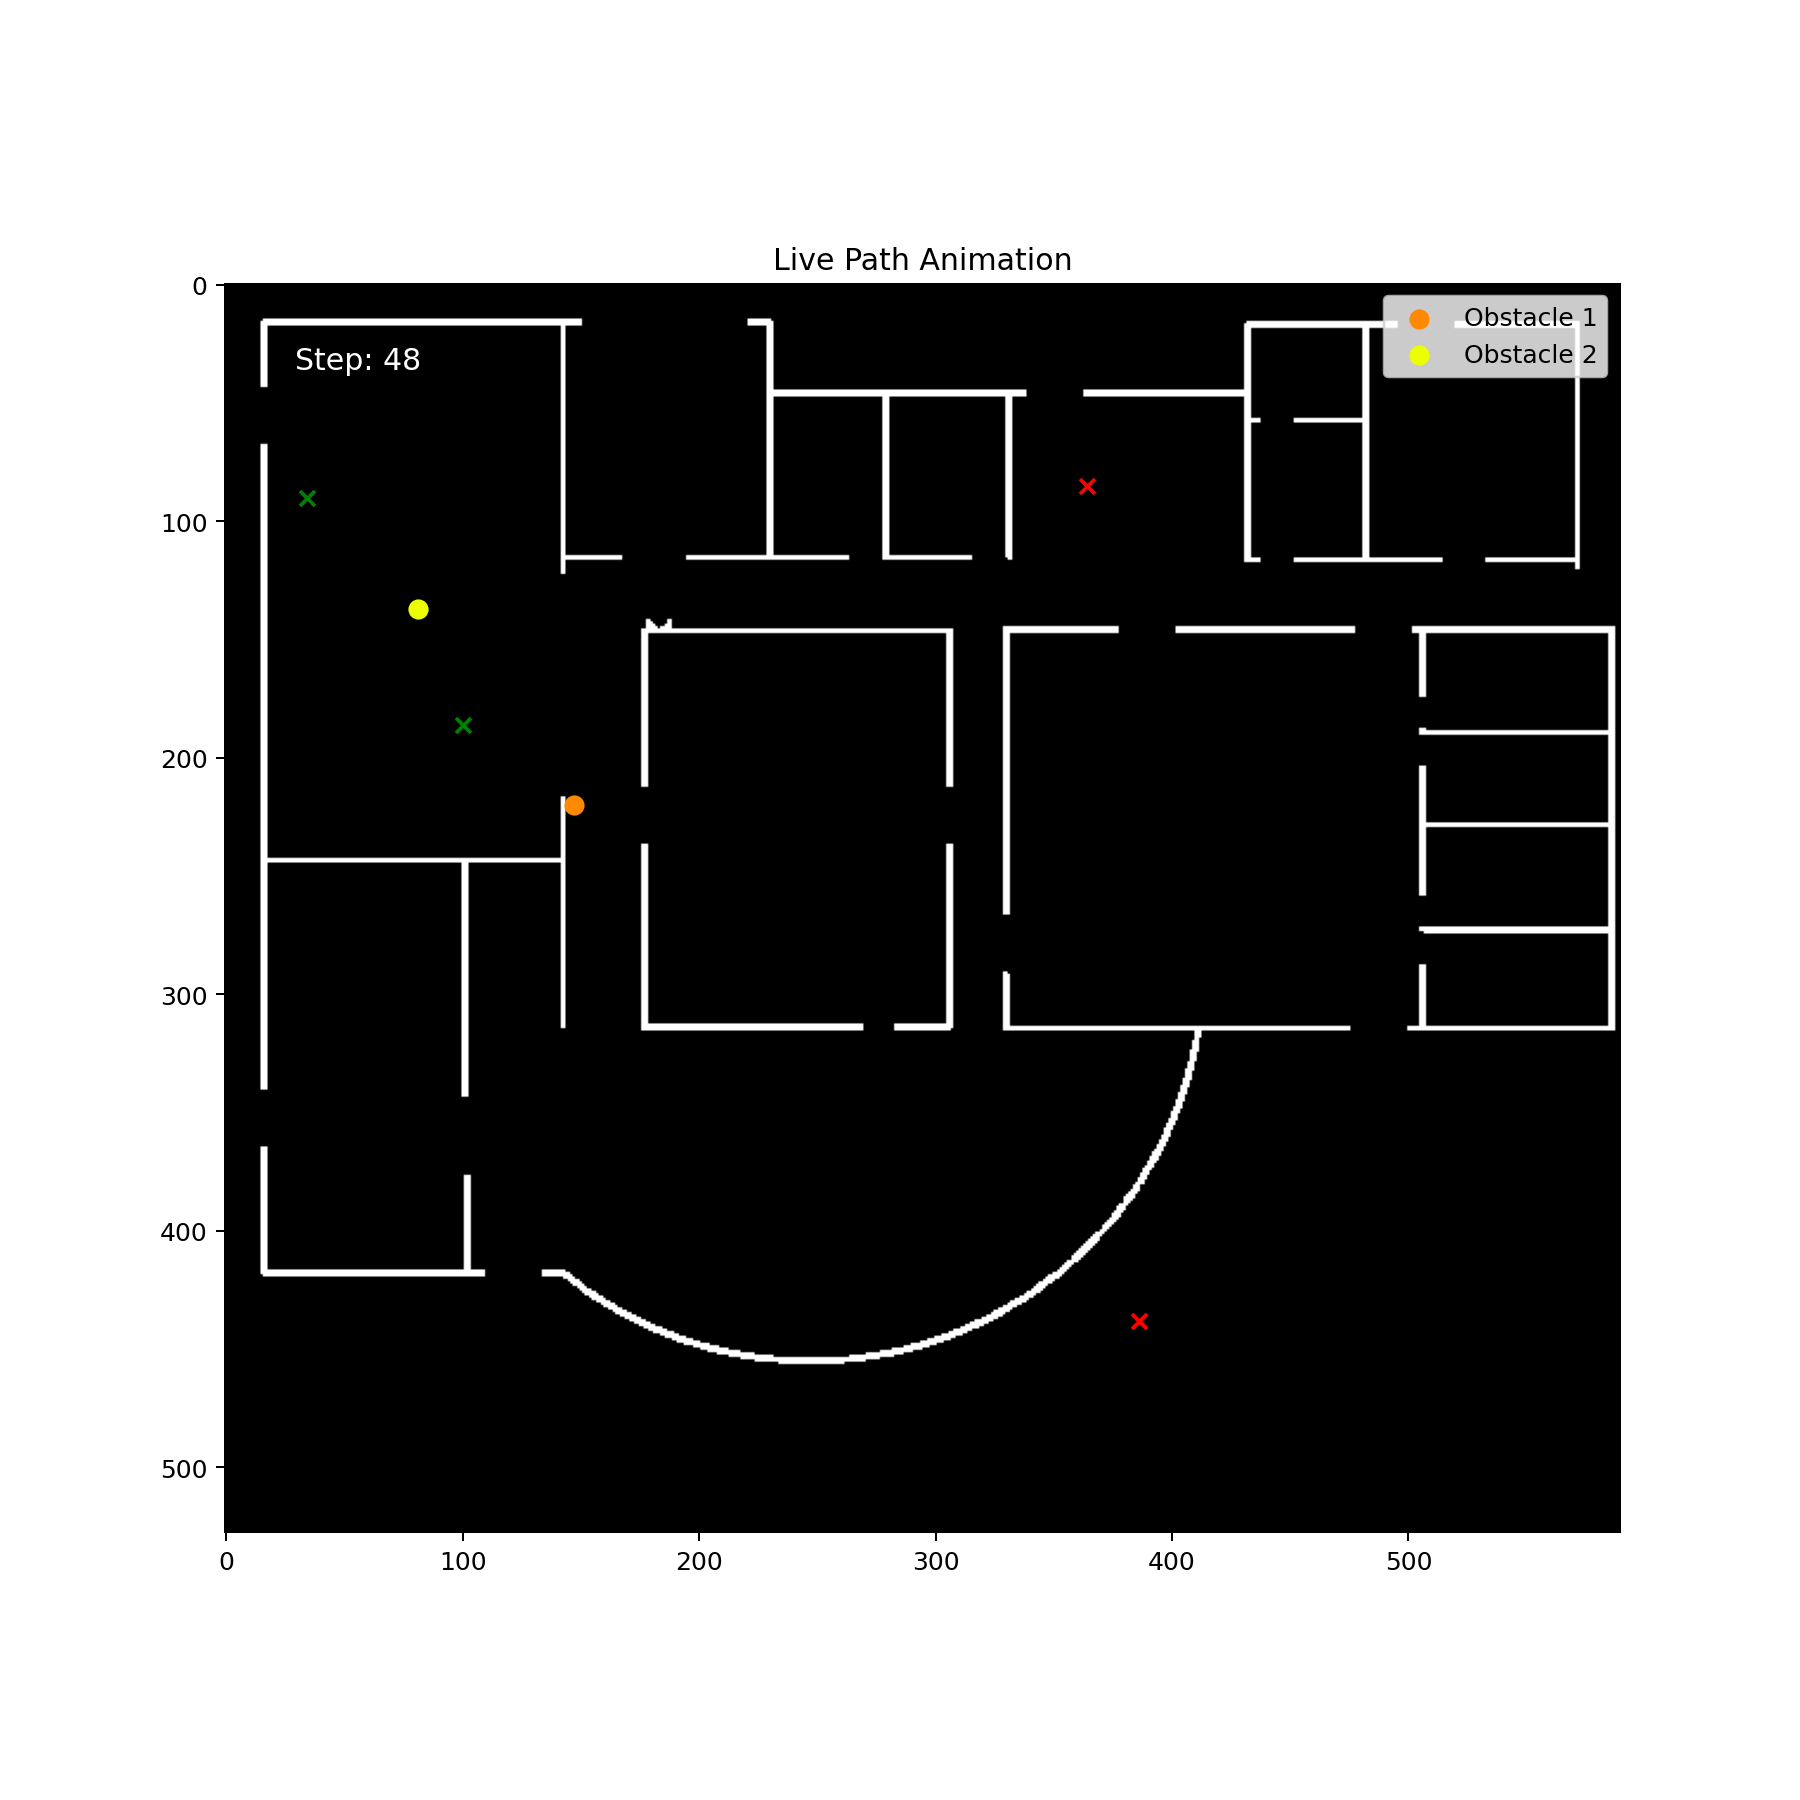

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_19660/3993815584.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', num_colors + 10)


In [7]:


# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i+1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for start and end
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
    ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
    ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=episode_length, fargs=[obstacle_paths, scatters], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()


# Intergration with Grouping Code and Stable Baseline 3

In [26]:
import os
import wandb

import obstacle_generator as observ

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

import heapq
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class DGSN_Env(gym.Env):
    def __init__(self, gridworld, obstacle_paths, occupied_time_steps, obstacle_occupied_points, number_of_obstacles, episode_length):
        super(DGSN_Env, self).__init__()
        print(f"It begins!")
        self.gridworld = gridworld
        self.grid_size = gridworld.shape
        
        self.obstacle_paths = obstacle_paths
        self.occupied_time_steps = occupied_time_steps
        self.obstacle_occupied_points = obstacle_occupied_points
        self.episode_length = episode_length
        self.boundary_threshold = 0
        self.max_dynamic_obstacles = number_of_obstacles
        self.num_static_obstacles = 0
        self.max_static_obstacles = 0
        self.number_of_obstacles = number_of_obstacles
        self.num_dynamic_obstacles = number_of_obstacles
        self.robot_position = None
        self.goal_position = None
        self.agent_pos = self.robot_position
        self.goal_pos = self.goal_position
        self.ep_no = 0
        self.global_obstacle_position = []
        self.close_call, self.discomfort, self.current_step, self.ep_no = 0, 0, 1, 0
        self.dist_factor = 4
        self.thresh = 1.5
        self.max_steps = episode_length
        self.total_reward = 0
        self.robot_path = []

        self.action_space = spaces.Discrete(9)  # 9 possible actions including no movement
        self.observation_space = spaces.Dict({
            'agent': spaces.Box(low=0, high=max(self.grid_size), shape=(2,), dtype=np.int32),
            'dyn_obs': spaces.Box(low=0, high=max(self.grid_size), shape=(number_of_obstacles, 2), dtype=np.int32)
        })
        
        self._initialize_robot_and_goal()
        self.dynamic_obstacles = self._init_dynamic_obstacles(obstacle_paths)
        
        wandb.login()
        wandb.init(project='DGSN_Finale')
        
        self.safe = True
        
        # Evaluation Metrics
        self.Avg_Success_Rate = 0
        self.Avg_Collision_Rate, self.ep_collision_rate, self.collision_count = 0, 0, 0
        self.Avg_Min_Time_To_Collision, self.min_time_to_collision = 0, 0
        self.Avg_Wall_Collision_Rate, self.ep_wall_collision_rate, self.wall_collision_count = 0, 0, 0
        self.Avg_Obstacle_Collision_Rate, self.ep_obstacle_collision_rate, self.obstacle_collision_count = 0, 0, 0
        self.Avg_Human_Collision_Rate, self.ep_human_collision_rate, self.human_collision_count = 0, 0, 0
        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.Avg_Stalled_Time, self.stalled_time = 0, 0
        self.Avg_Group_Inhibition_Rate, self.ep_group_inhibition_rate, self.group_inhibition = 0, 0, 0
        self.Avg_Discomfort, self.ep_discomfort = 0, 0
        self.Avg_Human_Distance, self.ep_human_distance, self.human_distance = 0, 0, 0
        self.Avg_Closest_Human_Distance, self.closest_human_distance = 0, 0
        self.Min_Closest_Human_Distance = 0
        self.goal_reached = 0
        self.timeout = 0
        
    def _initialize_robot_and_goal(self):
        # Find a free space for the robot start point
        self.robot_position = self._find_free_space()
        self.agent_pos = self.robot_position
        # Find a free space for the goal point
        self.goal_position = self._find_free_space()
        self.goal_pos = self.goal_position
        self.robot_path.append(self.robot_position) 
        
    def _find_free_space(self):
        free_spaces = np.argwhere(self.gridworld == 0)
        while True:
            candidate = tuple(free_spaces[np.random.choice(len(free_spaces))])
            if self._is_free_space(candidate):
                return candidate

    def _is_free_space(self, position):
        # Check if the position is occupied by any obstacle at the current time step
        if position in self.occupied_time_steps and self.occupied_time_steps[position] == self.current_step:
            return False
        # Check if the position is occupied by the robot or goal
        if position == self.robot_position or position == self.goal_position:
            return False
        return True

    def _init_dynamic_obstacles(self, obstacle_paths):
        obstacles = []
        for i in range(self.number_of_obstacles):
            start_pos = obstacle_paths[str(i+1)][0]
            end_pos = obstacle_paths[str(i+1)][-1]
            path = obstacle_paths[str(i+1)]
            distance = np.linalg.norm(np.array(self.agent_pos) - np.array(start_pos))
            obstacles.append({
                'start': start_pos,
                'end': end_pos,
                'current': start_pos,
                'angle': np.rad2deg(np.arctan2(self.agent_pos[1] - start_pos[1], self.agent_pos[0] - start_pos[0])).astype('float'),
                'distance': int(distance),
                'path': path if path else []
            })
        return obstacles
    
    def _check_goal_reached(self, position):
        return position == self.goal_position
    
    def _is_valid_move(self, position):
        
        
            

        """
        Check if the position is within grid bounds, is a free space (value 0), and is not occupied by any obstacle.
        """
    #         print(f"-----------checking if valid move---{position}-------")
        rows, cols = self.gridworld.shape
        if not (0 <= position[0] < rows and 0 <= position[1] < cols):
    #             print("going outside the world")
            return False
        if self.gridworld[position[0], position[1]] != 0:
    #             print("Collison with the wall")
            return False
        if position in self.occupied_time_steps and self.occupied_time_steps[position] == self.current_step:
    #             print("collision with an obstacle")
            return False
        return True

    
    def _compute_path(self, start, end):
        def heuristic(a, b):
            return np.linalg.norm(a - b)

        def a_star(start, goal):
            open_set = []
            heapq.heappush(open_set, (0, tuple(start)))
            came_from = {}
            g_score = {tuple(start): 0}
            f_score = {tuple(start): heuristic(start, goal)}

            while open_set:
                _, current = heapq.heappop(open_set)
                current = np.array(current)

                if np.array_equal(current, goal):
                    path = []
                    while tuple(current) in came_from:
                        path.append(current)
                        current = came_from[tuple(current)]
                    path.append(start)
                    path.reverse()
                    return path
                
                val = 0.1
                neighbors = [current + [val, 0], current + [-val, 0], current + [0, val], current + [0, -val]]
                neighbors = [np.clip(neighbor, 0, self.grid_size - 0.5) for neighbor in neighbors]

                for neighbor in neighbors:
                    tentative_g_score = g_score[tuple(current)] + heuristic(current, neighbor)
                    if tuple(neighbor) not in g_score or tentative_g_score < g_score[tuple(neighbor)]:
                        came_from[tuple(neighbor)] = current
                        g_score[tuple(neighbor)] = tentative_g_score
                        f_score[tuple(neighbor)] = tentative_g_score + heuristic(neighbor, goal)
                        heapq.heappush(open_set, (f_score[tuple(neighbor)], tuple(neighbor)))
            return []

        return a_star(start, end)
    
    def _get_obstacles_positions(self):
        obstacles_positions = {}
        for key, path in self.obstacle_paths.items():
            if self.current_step < len(path):
                obstacles_positions[key] = path[self.current_step]
        return obstacles_positions
    
    
    
    def _move(self, position, action):
        directions = [
            (0, 1), (1, 0), (0, -1), (-1, 0),  # Right, Down, Left, Up
            (-1, 1), (-1, -1), (1, 1), (1, -1),(0,0)  # Top-Right, Top-Left, Bottom-Right, Bottom-Left, No movement
        ]
        direction = directions[action]
        new_position = (position[0] + direction[0], position[1] + direction[1])
        return new_position
    
    def step(self, action):
        previous_agent_pos = self.robot_position
        new_position = self._move(self.robot_position, action)
        collision = not self._is_valid_move(new_position)
        goal_reached = self._check_goal_reached(new_position)
        
        if not collision:
            self.robot_position = new_position
            self.agent_pos = new_position
            obstacles_positions = self._get_obstacles_positions()
            self.global_obstacle_position = obstacles_positions
            self.current_step += 1
            self.robot_path.append(new_position)
        else:
            new_position = previous_agent_pos
            obstacles_positions = self.global_obstacle_position
            
        obs = self._get_obs()
        reward = self._compute_reward(previous_agent_pos)
        done = goal_reached or self.current_step >= self.episode_length
        truncated = self.current_step >= self.episode_length
        
        print(f"Agent's Current Position {previous_agent_pos}")
        print(f"Goal Position : {self.goal_pos}")
        print(f"Agent's New Position {self.agent_pos}")
        print(f"Steps taken : {self.current_step}")
        
        for i, obstacle in enumerate(self.dynamic_obstacles):
            if len(obstacle['path']) > 1:
                obstacle['current'] = obstacles_positions[str(i+1)]
        
        print(f"#####################################")
        print(f"Reward Obtained : {reward}")
        print(f"#####################################")
        
        self.total_reward += reward
        wandb.log({"Reward": reward, "Total_Reward": self.total_reward})
        
        self.done = self._is_done()
        if self.current_step >= self.max_steps:
            self.done = True
            reward -= 2500
            self.timeout += 1
            wandb.log({"TimeOut": self.timeout})
        
        return obs, reward, self.done, truncated, {}

    def _compute_reward(self, previous_agent_pos):
        reward_c = 0
        if self.safe:
            self.min_time_to_collision += 1
        previous_dist_to_goal = np.linalg.norm(np.array(previous_agent_pos) - np.array(self.goal_pos))
        current_dist_to_goal = np.linalg.norm(np.array(self.agent_pos) - np.array(self.goal_pos))
        del_distance = current_dist_to_goal - previous_dist_to_goal

        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n")
        print(f"Distance to the Goal : {current_dist_to_goal}")
        print(f"Del_Distance : {del_distance}")

        if del_distance > 0:
            reward_c -= del_distance * self.dist_factor
        elif del_distance == 0:
            reward_c = -2
        else:
            reward_c += (-del_distance) * self.dist_factor * 2

        print(f"Reward from Del_Dist : {reward_c}")

        for i, obs in enumerate(self.dynamic_obstacles):
            distance = np.linalg.norm(np.array(obs['current']) - np.array(self.agent_pos))
            self.human_distance += distance
            print(f"******************************")
            print(f"Obstacle #{i} Distance : {distance}")

            if distance < 3 and distance != 0:  
                self.closest_human_distance = min(self.closest_human_distance, distance)
                self.close_call += 1
                pen_1 = (10 / distance) * 2
                reward_c -= pen_1  
                print(f"Penalty Obtained : {pen_1}")

        print(f"Reward Post Dynamic Manouevres : {reward_c}")
        print(f"******************************")

        grouped_obstacles = self._group_dynamic_obstacles()
        for j, group in enumerate(grouped_obstacles):
            group_center = np.mean(group, axis=0)
            if np.linalg.norm(np.array(self.agent_pos) - group_center) < self.thresh:                
                reward_c -= 50
                self.group_inhibition += 1
                self.close_call += 1
                print(f"Oops Inhibited the Group {j} - Penalty -50")
                wandb.log({"Group_Inhibition": self.group_inhibition})

        if any(np.array_equal(self.agent_pos, np.array(obs['current'])) for obs in self.dynamic_obstacles):
            self.collision_count += 1
            self.human_collision_count += 1
            self.safe = False
            reward_c -= 30  
            print(f"Collided with a Human!!!")
            print(f"Post Human Collision Reward : {reward_c}")

        if np.any(np.array(self.agent_pos) <= self.boundary_threshold) or np.any(np.array(self.agent_pos) >= np.array(self.grid_size) - self.boundary_threshold):
            reward_c -= 15  
            print(f"Pretty Close to the Boundary!!!")
            print(f"Post Boundary Penalty Reward : {reward_c}")

        if np.any(np.array(self.agent_pos) == 0) or np.any(np.array(self.agent_pos) >= np.array(self.grid_size)):
            self.collision_count += 1
            self.wall_collision_count += 1
            self.safe = False
            reward_c -= 20  
            print(f"Collided with the wall!!!")
            print(f"Post Wall Collision Reward : {reward_c}")

        reward_c -= 1

        if self._is_done():
            reward_c += 3000
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n")
            print(f"Goal Reached!!!!!")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n")
            self.goal_reached += 1
            wandb.log({'Goal_Reached': self.goal_reached})

        return reward_c

    
    def _is_done(self):
        return np.array_equal(np.array(self.agent_pos), np.array(self.goal_pos))
    
    def _get_obs(self):
        agent_state = np.array([self.agent_pos[0], self.agent_pos[1]], dtype=np.int32)
        
        dynamic_obstacle_states = np.array(
            [(np.rad2deg(np.arctan2(self.agent_pos[1] - ob['current'][1], self.agent_pos[0] - ob['current'][0])), 
              np.linalg.norm(np.array(self.agent_pos) - np.array(ob['current']))) 
             for ob in self.dynamic_obstacles] + 
            [np.zeros(2, dtype=np.int32) for _ in range(self.max_dynamic_obstacles - len(self.dynamic_obstacles))], 
            dtype=np.int32)

        return {
            'agent': agent_state,
            'dyn_obs': dynamic_obstacle_states
        }
    

        
    def _group_dynamic_obstacles(self):
        positions = np.array([np.array(obs['current']) for obs in self.dynamic_obstacles])
        clustering = DBSCAN(eps=0.3, min_samples=2).fit(positions)
        labels = clustering.labels_

        grouped_obstacles = []
        for label in set(labels):
            if label != -1:
                group = positions[labels == label]
                grouped_obstacles.append(group)
        return grouped_obstacles
    
    def render(self, mode='human'):
        pass
    
    def reset(self, **kwargs):
        print("PRINTING & LOGGING!!!")
        wandb.log({"Episode": self.ep_no})  
        self.ep_no += 1

        if self.current_step > 0:
            self.ep_human_distance = self.human_distance / (self.num_dynamic_obstacles * self.current_step)
            self.ep_discomfort = self.close_call / self.current_step
            self.ep_collision_rate = self.collision_count / self.current_step
            self.ep_wall_collision_rate = self.wall_collision_count / self.current_step
            self.ep_obstacle_collision_rate = self.obstacle_collision_count / self.current_step
            self.ep_human_collision_rate = self.human_collision_count / self.current_step
            self.ep_group_inhibition_rate = self.group_inhibition / self.current_step
        else:
            self.ep_human_distance = 0
            self.ep_discomfort = 0
            self.ep_collision_rate = 0
            self.ep_wall_collision_rate = 0
            self.ep_obstacle_collision_rate = 0
            self.ep_human_collision_rate = 0
            self.ep_group_inhibition_rate = 0

        self.Avg_Collision_Rate = ((self.ep_no - 1) * self.Avg_Collision_Rate + self.ep_collision_rate) / self.ep_no
        self.Avg_Min_Time_To_Collision = ((self.ep_no - 1) * self.Avg_Min_Time_To_Collision + self.min_time_to_collision) / self.ep_no
        self.Avg_Wall_Collision_Rate = ((self.ep_no - 1) * self.Avg_Wall_Collision_Rate + self.ep_wall_collision_rate) / self.ep_no
        self.Avg_Obstacle_Collision_Rate = ((self.ep_no - 1) * self.Avg_Obstacle_Collision_Rate + self.ep_obstacle_collision_rate) / self.ep_no
        self.Avg_Human_Collision_Rate = ((self.ep_no - 1) * self.Avg_Human_Collision_Rate + self.ep_human_collision_rate) / self.ep_no
        self.Avg_Path_Length = ((self.ep_no - 1) * self.Avg_Path_Length + self.current_step) / self.ep_no
        self.Avg_Stalled_Time = ((self.ep_no - 1) * self.Avg_Stalled_Time + self.stalled_time) / self.ep_no
        self.Avg_Discomfort = ((self.ep_no - 1) * self.Avg_Discomfort + self.ep_discomfort) / self.ep_no
        self.Avg_Human_Distance = ((self.ep_no - 1) * self.Avg_Human_Distance + self.ep_human_distance) / self.ep_no
        self.Avg_Closest_Human_Distance = ((self.ep_no - 1) * self.Avg_Closest_Human_Distance + self.closest_human_distance) / self.ep_no
        self.Avg_Group_Inhibition_Rate = ((self.ep_no - 1) * self.Avg_Group_Inhibition_Rate + self.ep_group_inhibition_rate) / self.ep_no
        
        wandb.log({
            "Ep_Total_Reward": self.total_reward, 
            "Ep_Collision_Count": self.collision_count, "Ep_Min_Time_To_Collision": self.min_time_to_collision, 
            "Ep_Wall_Collision_Count": self.wall_collision_count, "Ep_Obstacle_Collision_Count": self.obstacle_collision_count, 
            "Ep_Human_Collision_Count": self.human_collision_count, "Ep_Collision_Rate": self.ep_collision_rate,
            "Ep_Wall_Collision_Rate": self.ep_wall_collision_rate, "Ep_Obstacle_Collision_Rate": self.ep_obstacle_collision_rate,
            "Ep_Human_Collision_Rate": self.ep_human_collision_rate, "Ep_Path_Length": self.current_step,
            "Ep_Stalled_Time": self.stalled_time, "Ep_Discomfort": self.ep_discomfort,
            "Ep_Avg_Human_Distance": self.ep_human_distance, "Ep_Closest_Human_Distance": self.closest_human_distance,
            "Ep_Close_Calls": self.close_call, "Ep_Group_Inhibition": self.ep_group_inhibition_rate,
            "Avg_Collision_Rate": self.Avg_Collision_Rate, "Avg_Min_Time_To_Collision": self.Avg_Min_Time_To_Collision,
            "Avg_Wall_Collision_Rate": self.Avg_Wall_Collision_Rate, "Avg_Obstacle_Collision_Rate": self.Avg_Obstacle_Collision_Rate,
            "Avg_Human_Collision_Rate": self.Avg_Human_Collision_Rate, "Avg_Path_Length": self.Avg_Path_Length,
            "Avg_Stalled_Time": self.Avg_Stalled_Time, "Avg_Discomfort": self.Avg_Discomfort,
            "Avg_Human_Distance": self.Avg_Human_Distance, "Avg_Closest_Human_Distance": self.Avg_Closest_Human_Distance,
            "Avg_Group_Inhibition_Rate": self.Avg_Group_Inhibition_Rate
        })
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print(f"RUN DETAILS!!! \n")
        print(f"Ep_Total_Reward : {self.total_reward} \n"), 
        print(f"Ep_Collision_Count : {self.collision_count}")
        print(f"Ep_Wall_Collision_Count : {self.wall_collision_count}")
        print(f"Ep_Obstacle_Collision_Count : {self.obstacle_collision_count}")
        print(f"Ep_Human_Collision_Count : {self.human_collision_count}")
        print(f"Ep_Min_Time_To_Collision : {self.min_time_to_collision}")
        print(f"Ep_Stalled_Time : {self.stalled_time}")
        print(f"Ep_Avg_Human_Distance : {self.Avg_Human_Distance}")
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print("Creating the new Episode")
        
        if 'seed' in kwargs:
            np.random.seed(kwargs['seed'])
        
        pathfinder = observ.Pathfinding(self.gridworld)
        self.obstacle_paths = pathfinder.generate_paths(self.number_of_obstacles, self.episode_length)
        self.occupied_time_steps = pathfinder.occupied_time_steps
        self.obstacle_occupied_points = pathfinder.obstacle_occupied_points
        self.robot_position = None
        self.goal_position = None
        self.current_step = 0
        self.global_obstacle_position = []
        self.robot_path = []
        self._initialize_robot_and_goal()
        
        self.agent_pos = self.robot_position
        self.goal_pos = self.goal_position
        self.num_static_obstacles = 0
        self.num_dynamic_obstacles = len(self.obstacle_paths)
        
        self.dynamic_obstacles = self._init_dynamic_obstacles(self.obstacle_paths)
        self.safe = True
        self.done = False
        
        self.Avg_Success_Rate = 0
        self.ep_collision_rate, self.collision_count = 0, 0
        self.min_time_to_collision = 0
        self.ep_wall_collision_rate, self.wall_collision_count = 0, 0
        self.ep_obstacle_collision_rate, self.obstacle_collision_count = 0, 0
        self.ep_human_collision_rate, self.human_collision_count = 0, 0
        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.stalled_time = 0
        self.ep_group_inhibition_rate, self.group_inhibition = 0, 0
        self.ep_discomfort = 0
        self.ep_human_distance, self.human_distance = 0, 0
        self.closest_human_distance = 0
        self.Min_Closest_Human_Distance = 0
        self.close_call, self.discomfort, self.current_step = 0, 0, 1
        self.total_reward = 0
        
        print("*******************************************************************\n")
        print("Initialized the environment with the following")
        print("Agent's Initial Position :", self.agent_pos)
        print("Goal Position :", self.goal_pos)
        print("Number of Dynamic Obstacles :", self.num_dynamic_obstacles)
        print("Dynamic Obstacle theta & dist :", self.dynamic_obstacles, "\n")
        print("*******************************************************************")
        
        return self._get_obs(), {}

class CustomCallback(BaseCallback):
    def __init__(self, env, render_freq=1, save_freq=100, save_path=None, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.env = env
        self.render_freq = render_freq
        self.save_freq = save_freq
        self.save_path = save_path

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            self.env.render()
        
        if self.n_calls % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.n_calls}.zip")
            self.model.save(save_file)
            if self.verbose > 0:
                print(f"Model saved at step {self.n_calls} to {save_file}")
        
        return True

env = DGSN_Env(gridworld, obstacle_paths, occupied_time_steps, obstacle_occupied_points, number_of_obstacles, episode_length)
obs = env.reset()

log_path = os.path.join('Train','Logs')
save_path = os.path.join('Train', 'Saved_Models', 'PPO_1')

combined_callback = CustomCallback(env=env, render_freq=1, save_freq=100, save_path=save_path, verbose=1)
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path, device='cpu', n_epochs=1000)

model.learn(total_timesteps=10000000, callback=combined_callback)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


It begins!


Avg_Closest_Human_Distance,▁▁▁▁▁▁▁▁▁▁
Avg_Collision_Rate,▁▁▁▁▁█▇▆▆▅
Avg_Discomfort,▁▁▁▁▁▁▁▁▁▁
Avg_Group_Inhibition_Rate,▁▁▁▁▁▁▁▁▁▁
Avg_Human_Collision_Rate,▁▁▁▁▁▁▁▁▁▁
Avg_Human_Distance,▁▁▃▅▇█████
Avg_Min_Time_To_Collision,▁▁▄▅▆▇▇███
Avg_Obstacle_Collision_Rate,▁▁▁▁▁▁▁▁▁▁
Avg_Path_Length,▁▁█▆▅▄▄▄▃▃
Avg_Stalled_Time,▁▁▁▁▁▁▁▁▁▁
Avg_Wall_Collision_Rate,▁▁▁▁▁█▇▆▆▅


PRINTING & LOGGING!!!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
RUN DETAILS!!! 

Ep_Total_Reward : 0 

Ep_Collision_Count : 0
Ep_Wall_Collision_Count : 0
Ep_Obstacle_Collision_Count : 0
Ep_Human_Collision_Count : 0
Ep_Min_Time_To_Collision : 0
Ep_Stalled_Time : 0
Ep_Avg_Human_Distance : 0.0
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Creating the new Episode
*******************************************************************

Initialized the environment with the following
Agent's Initial Position : (506, 285)
Goal Position : (477, 231)
Number of Dynamic Obstacles : 2
Dynamic Obstacle theta & dist : [{'start': (308, 267), 'end': (281, 443), 'current': (308, 267), 'angle': 5.194428907734806, 'distance': 198, 'path': [(308, 267), (309, 268), (310, 269), (311, 270), (312, 271), (313, 272), (314, 273), (315, 274), (316, 275), (317, 276), (318, 277), (319, 278), (320, 279), (321, 280), (322, 281), (323, 282), (324, 283), (325, 284), (326, 285), (327, 286), (328, 287), (329, 288), (330,

*******************************************************************

Initialized the environment with the following
Agent's Initial Position : (197, 339)
Goal Position : (513, 328)
Number of Dynamic Obstacles : 2
Dynamic Obstacle theta & dist : [{'start': (28, 310), 'end': (424, 138), 'current': (28, 310), 'angle': 9.736988270402748, 'distance': 171, 'path': [(28, 310), (29, 309), (30, 308), (31, 307), (32, 306), (33, 305), (34, 304), (35, 303), (36, 302), (37, 301), (38, 300), (39, 299), (40, 298), (41, 297), (42, 296), (43, 295), (44, 294), (44, 293), (44, 292), (44, 291), (44, 290), (44, 289), (44, 288), (44, 287), (44, 286), (44, 285), (44, 284), (44, 283), (44, 282), (44, 281), (44, 280), (44, 279), (44, 278), (44, 277), (44, 276), (44, 275), (44, 274), (44, 273), (44, 272), (44, 271), (44, 270), (44, 269), (44, 268), (44, 267), (44, 266), (44, 265), (44, 264), (44, 263), (44, 262), (44, 261), (44, 260), (43, 259), (42, 258), (41, 257), (40, 256), (39, 255), (38, 254), (37, 253), 

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 316.1913977324494
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 171.47011401407536
******************************
Obstacle #1 Distance : 188.2471779336944
Reward Post Dynamic Manouevres : -2
******************************
Agent's Current Position (197, 339)
Goal Position : (513, 328)
Agent's New Position (197, 339)
Steps taken : 2
#####################################
Reward Obtained : -3
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 316.1913977324494
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 170.6575518399347
******************************
Obstacle #1 Distance : 187.1069213043708
Reward Post Dynamic Manouevres : -2
******************************
Agent's Current Position (197, 339)
Goal Position : (51

Agent's Current Position (176, 364)
Goal Position : (513, 328)
Agent's New Position (177, 364)
Steps taken : 184
#####################################
Reward Obtained : 6.954607179121467
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 336.82339586198583
Del_Distance : -1.099672305903539
Reward from Del_Dist : 8.797378447228311
******************************
Obstacle #0 Distance : 181.077331546497
******************************
Obstacle #1 Distance : 38.48376280978771
Reward Post Dynamic Manouevres : 8.797378447228311
******************************
Agent's Current Position (177, 364)
Goal Position : (513, 328)
Agent's New Position (178, 363)
Steps taken : 185
#####################################
Reward Obtained : 7.797378447228311
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 337.8179983363823
Del_Distance : 0.99460247

Goal Position : (513, 328)
Agent's New Position (194, 370)
Steps taken : 368
#####################################
Reward Obtained : 7.985011020712591
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 320.6321880285883
Del_Distance : -1.1208228353351046
Reward from Del_Dist : 8.966582682680837
******************************
Obstacle #0 Distance : 216.8985938174796
******************************
Obstacle #1 Distance : 137.71347065556077
Reward Post Dynamic Manouevres : 8.966582682680837
******************************
Agent's Current Position (194, 370)
Goal Position : (513, 328)
Agent's New Position (195, 369)
Steps taken : 369
#####################################
Reward Obtained : 7.966582682680837
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 320.50585018061685
Del_Distance : -0.12633784797145609
Reward from Del_Dist :

*******************************************************************

Initialized the environment with the following
Agent's Initial Position : (65, 103)
Goal Position : (199, 349)
Number of Dynamic Obstacles : 2
Dynamic Obstacle theta & dist : [{'start': (400, 164), 'end': (446, 188), 'current': (400, 164), 'angle': -169.6801034187582, 'distance': 340, 'path': [(400, 164), (401, 163), (402, 162), (403, 161), (404, 160), (405, 159), (406, 158), (407, 157), (408, 156), (409, 155), (410, 154), (411, 153), (412, 152), (413, 151), (414, 150), (415, 149), (416, 148), (417, 147), (418, 146), (417, 145), (417, 144), (416, 143), (416, 142), (416, 141), (416, 140), (416, 139), (416, 138), (416, 137), (416, 136), (416, 135), (416, 134), (417, 133), (418, 132), (419, 131), (420, 130), (421, 129), (422, 128), (423, 127), (424, 126), (425, 125), (426, 124), (427, 123), (428, 122), (429, 121), (430, 120), (431, 119), (432, 118), (433, 117), (434, 116), (435, 115), (436, 114), (437, 113), (438, 112), 

Agent's New Position (84, 111)
Steps taken : 184
#####################################
Reward Obtained : 2.4927796416500314
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 264.3274484422683
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 400.98129632191075
******************************
Obstacle #1 Distance : 376.4306044943742
Reward Post Dynamic Manouevres : -2
******************************
Agent's Current Position (84, 111)
Goal Position : (199, 349)
Agent's New Position (84, 111)
Steps taken : 185
#####################################
Reward Obtained : -3
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 263.4274093559742
Del_Distance : -0.9000390862941003
Reward from Del_Dist : 7.200312690352803
******************************
Obstacle #0 Distance : 400.98129632191075


******************************
Obstacle #1 Distance : 437.1773095667249
Reward Post Dynamic Manouevres : 3.99535956776117
******************************
Agent's Current Position (89, 104)
Goal Position : (199, 349)
Agent's New Position (88, 105)
Steps taken : 391
#####################################
Reward Obtained : 2.99535956776117
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 267.56868277135874
Del_Distance : -0.49287732258682126
Reward from Del_Dist : 3.94301858069457
******************************
Obstacle #0 Distance : 410.18288603987367
******************************
Obstacle #1 Distance : 437.90524089122295
Reward Post Dynamic Manouevres : 3.94301858069457
******************************
Agent's Current Position (88, 105)
Goal Position : (199, 349)
Agent's New Position (87, 106)
Steps taken : 392
#####################################
Reward Obtained : 2.94301858069457
#########################

*******************************************************************

Initialized the environment with the following
Agent's Initial Position : (330, 229)
Goal Position : (172, 36)
Number of Dynamic Obstacles : 2
Dynamic Obstacle theta & dist : [{'start': (484, 150), 'end': (58, 250), 'current': (484, 150), 'angle': 152.842765470793, 'distance': 173, 'path': [(484, 150), (483, 150), (482, 150), (481, 150), (480, 150), (479, 150), (478, 150), (477, 150), (476, 150), (475, 150), (474, 150), (473, 150), (472, 150), (471, 150), (470, 150), (469, 150), (468, 150), (467, 150), (466, 150), (465, 150), (464, 150), (463, 150), (462, 150), (461, 150), (460, 150), (459, 150), (458, 150), (457, 150), (456, 150), (455, 150), (454, 150), (453, 150), (452, 150), (451, 150), (450, 150), (449, 150), (448, 150), (447, 150), (446, 150), (445, 150), (444, 150), (443, 150), (442, 150), (441, 150), (440, 150), (439, 150), (438, 150), (437, 150), (436, 150), (435, 149), (434, 148), (433, 147), (432, 146), (43

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 258.2576233143951
Del_Distance : 0.046469411237808345
Reward from Del_Dist : -0.18587764495123338
******************************
Obstacle #0 Distance : 90.69729874698585
******************************
Obstacle #1 Distance : 142.68847185389575
Reward Post Dynamic Manouevres : -0.18587764495123338
******************************
Agent's Current Position (349, 224)
Goal Position : (172, 36)
Agent's New Position (348, 225)
Steps taken : 189
#####################################
Reward Obtained : -1.1858776449512334
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 258.2576233143951
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 91.2633551870629
******************************
Obstacle #1 Distance : 141.8344104933637
Reward Post Dynamic Manouevres : -2
****************

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 284.01584462842914
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 247.42069436488129
******************************
Obstacle #1 Distance : 119.9208072020865
Reward Post Dynamic Manouevres : -2
******************************
Agent's Current Position (361, 248)
Goal Position : (172, 36)
Agent's New Position (361, 248)
Steps taken : 374
#####################################
Reward Obtained : -3
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 282.60396317107796
Del_Distance : -1.4118814573511713
Reward from Del_Dist : 11.29505165880937
******************************
Obstacle #0 Distance : 246.1097316239242
******************************
Obstacle #1 Distance : 120.7683733433551
Reward Post Dynamic Manouevres : 11.29505165880937
******************************
Agent'

*******************************************************************

Initialized the environment with the following
Agent's Initial Position : (349, 307)
Goal Position : (168, 521)
Number of Dynamic Obstacles : 2
Dynamic Obstacle theta & dist : [{'start': (471, 127), 'end': (413, 484), 'current': (471, 127), 'angle': 124.12854707414516, 'distance': 217, 'path': [(471, 127), (470, 128), (469, 129), (468, 130), (467, 131), (466, 132), (465, 133), (464, 134), (463, 135), (462, 136), (461, 137), (460, 138), (459, 139), (458, 140), (457, 141), (456, 142), (455, 143), (454, 144), (453, 145), (452, 146), (451, 147), (450, 148), (449, 149), (448, 150), (447, 151), (446, 152), (445, 153), (444, 154), (443, 155), (442, 156), (441, 155), (440, 154), (439, 153), (438, 152), (437, 151), (436, 150), (435, 149), (434, 148), (433, 147), (432, 146), (431, 145), (430, 144), (429, 143), (428, 142), (427, 141), (426, 140), (425, 139), (424, 138), (423, 137), (422, 136), (421, 135), (420, 134), (419, 133),

Agent's Current Position (336, 304)
Goal Position : (168, 521)
Agent's New Position (336, 305)
Steps taken : 188
#####################################
Reward Obtained : 5.320311607872554
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 273.64210202379314
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstacle #0 Distance : 43.829214001622255
******************************
Obstacle #1 Distance : 203.3420763147657
Reward Post Dynamic Manouevres : -2
******************************
Agent's Current Position (336, 305)
Goal Position : (168, 521)
Agent's New Position (336, 305)
Steps taken : 189
#####################################
Reward Obtained : -3
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 273.64210202379314
Del_Distance : 0.0
Reward from Del_Dist : -2
******************************
Obstac

Agent's Current Position (335, 320)
Goal Position : (168, 521)
Agent's New Position (334, 319)
Steps taken : 369
#####################################
Reward Obtained : -1.535597115896735
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 260.82369524259104
Del_Distance : -0.6337582751849595
Reward from Del_Dist : 5.070066201479676
******************************
Obstacle #0 Distance : 126.58988901172162
******************************
Obstacle #1 Distance : 225.07776433935007
Reward Post Dynamic Manouevres : 5.070066201479676
******************************
Agent's Current Position (334, 319)
Goal Position : (168, 521)
Agent's New Position (333, 319)
Steps taken : 370
#####################################
Reward Obtained : 4.070066201479676
#####################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 260.049995193232
Del_Distance : -0.773

KeyboardInterrupt: 

# Visualization Code

<IPython.core.display.Javascript object>


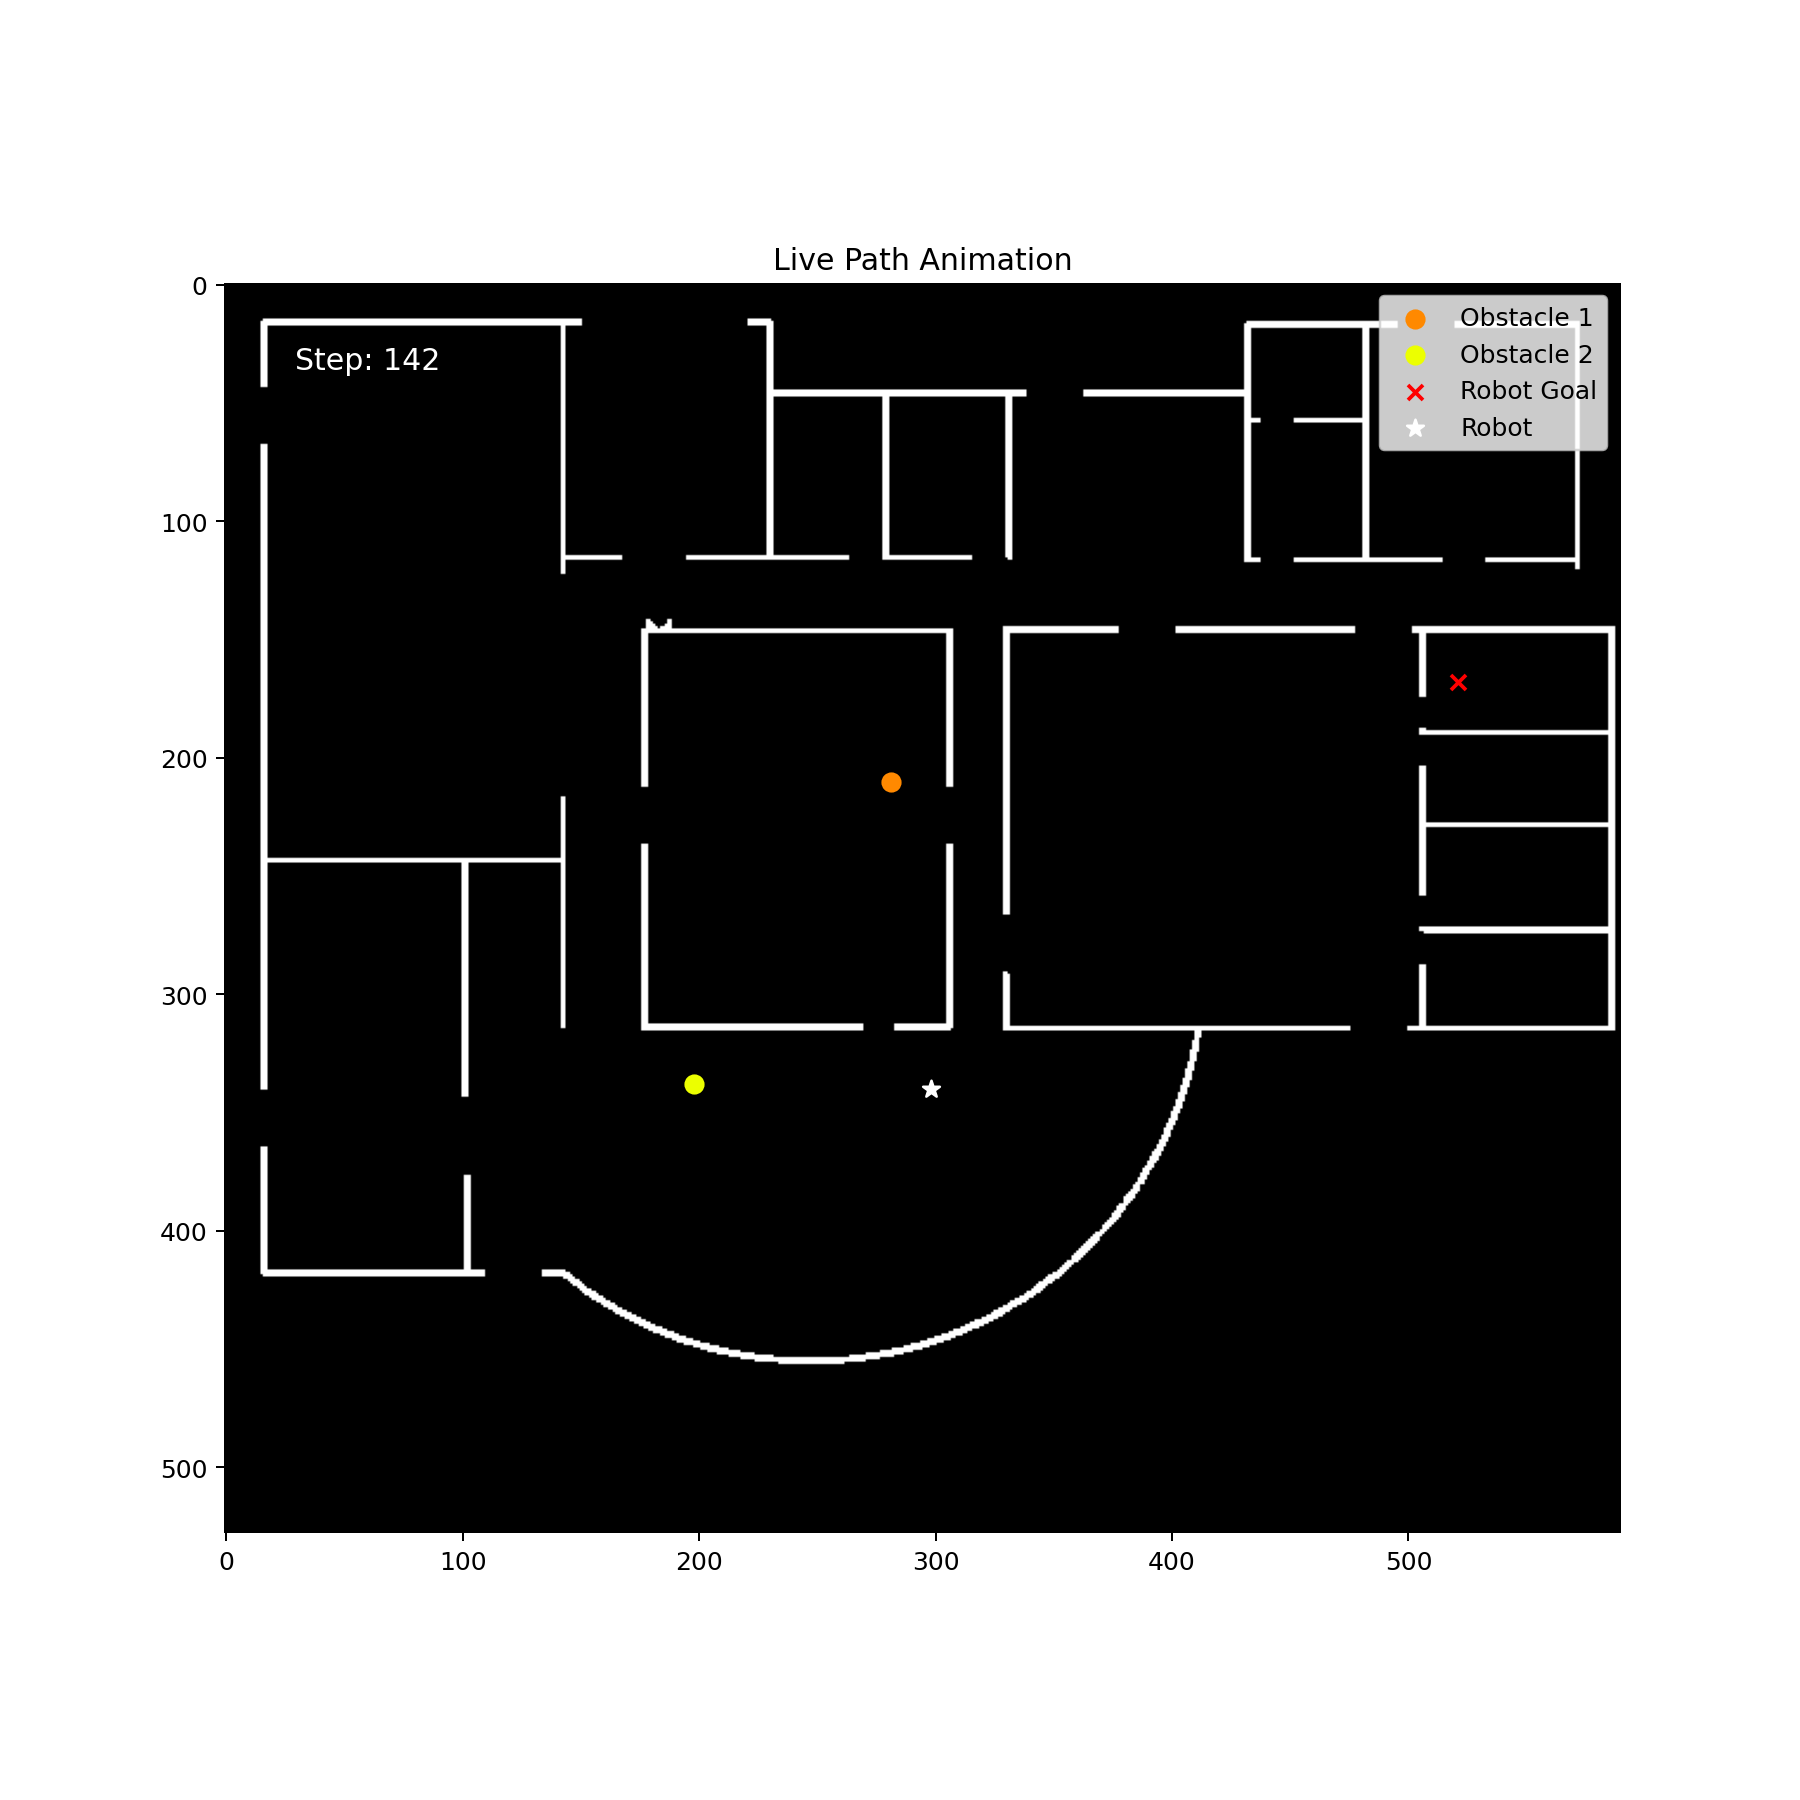

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_31210/3497567236.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', num_colors + 10)


In [28]:
%matplotlib notebook
robotPath = env.robot_path  # Get the path taken by the robot
# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for the robot's start and goal positions
robot_start = robotPath[0]
robot_goal = env.goal_position
# ax.scatter([robot_start[1]], [robot_start[0]], c='green', marker='^', label='Robot Start')
ax.scatter([robot_goal[1]], [robot_goal[0]], c='red', marker='x', label='Robot Goal')

# Initialize the scatter points for start and end of obstacles
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
#     ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
#     ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

# Initialize a scatter plot for the robot's current position
robot_scatter = ax.scatter([], [], color='white', s=50, marker='*', label='Robot')
scatters.append(robot_scatter)

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters, robot_path):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    
    if num < len(robot_path):
        scatters[-1].set_offsets([robot_path[num][1], robot_path[num][0]])
    
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())
max_path_length = max(max_path_length, len(robotPath))

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=max_path_length, fargs=[obstacle_paths, scatters, robotPath], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()

# ROBOT Training using Standard BaseLine Model 3 Library

In [6]:


# Create the RL environment
env = baseline.RLEnvironment(gridworld, obstacle_paths, occupied_time_steps, obstacle_occupied_points, number_of_obstacles, episode_length)

# Check the environment
check_env(env, warn=True)

# Ensure the log directory exists
log_path = "./ppo_logs/"
os.makedirs(log_path, exist_ok=True)

# Create the PPO model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path, device=device, n_epochs=100)

# Train the model
model.learn(total_timesteps=total_timesteps)

# Save the model
model.save("ppo_robot_env")

# Load the model
model = PPO.load("ppo_robot_env")

# Enjoy trained agent
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    
    # Print statements for debugging and tracking
    print(f"Step: {step}, Action: {action}")
    print(f"Robot Position: {env.robot_position}, Goal Position: {env.goal_position}")
    print(f"Collision: {info.get('collision', False)}, Goal Reached: {info.get('goal_reached', False)}")
    
    
    env.render()
    if dones:
        break

robotPath = env.robot_path  # Get the path taken by the robot



/Users/apple/ilgc/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:251: UserWarning: Your observation obstacles_positions has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Step: 1, Action: 1, Position: (186, 433), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (356, 536), '2': (425, 470)}
Step: 1, Action: 5, Position: (345, 290), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (196, 448), '2': (384, 291)}
Step: 2, Action: 8, Position: (345, 290), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (195, 447), '2': (385, 290)}
Step: 3, Action: 7, Position: (346, 289), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (194, 446), '2': (386, 289)}
Step: 4, Action: 0, Position: (346, 290), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (193, 445), '2': (387, 288)}
Step: 5, Action: 4, Position: (345, 291), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (192, 444), '2': (388, 287)}
Step: 6, Action: 0, Position: (345, 292), Collision: False, Goal Reached: False
Obstacle Positions: {'1': (191, 443), '2': (389, 286)}
Step: 7, Action: 2, Position: (345, 291), Collision: Fa

IndexError: list index out of range

# Visualization Code

In [ ]:
%matplotlib notebook

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for the robot's start and goal positions
robot_start = robotPath[0]
robot_goal = env.goal_position
# ax.scatter([robot_start[1]], [robot_start[0]], c='green', marker='^', label='Robot Start')
ax.scatter([robot_goal[1]], [robot_goal[0]], c='red', marker='x', label='Robot Goal')

# Initialize the scatter points for start and end of obstacles
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
#     ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
#     ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

# Initialize a scatter plot for the robot's current position
robot_scatter = ax.scatter([], [], color='white', s=50, marker='*', label='Robot')
scatters.append(robot_scatter)

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters, robot_path):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    
    if num < len(robot_path):
        scatters[-1].set_offsets([robot_path[num][1], robot_path[num][0]])
    
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())
max_path_length = max(max_path_length, len(robotPath))

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=max_path_length, fargs=[obstacle_paths, scatters, robotPath], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()

# ROBOT Training using an algo from scratch

In [35]:

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]


# Create the RL environment
env = robo.RLEnvironment(gridworld, obstacle_paths, occupied_time_steps, obstacle_occupied_points, number_of_obstacles, episode_length)

#storing the robot start position
robotPath = [env.robot_position]

# Example step through the environment
actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Possible actions
action = 3
episode = 2

for i in range(episode):
    print(f"=================####################episode number: {i}")
    if i > 0:
        
        
        print("resetting environment")
        env.reset()
        robotPath = [env.robot_position]
        action = 3

    for _ in range(episode_length):

        new_position, obstacles_positions, collision, goal_reached = env.step(action)

        #random alog movement
        if collision:
            action =  np.random.choice(actions)

        print(f"Step:{env.current_step}, Position:{new_position}, Collision:{collision}, Goal Reached:{goal_reached}, Current Step:{env.current_step}, Goal coordinate:{env.goal_position}")
        print(f"        Position of Obstacles: {obstacles_positions}")
        print()
        robotPath.append(new_position)
        
        '''
        Write your own custom RL algo and train it from scratch.
        
        '''

        if goal_reached:
            print("Goal reached!")
            break
    
[(12,3),(12,5)]

action taken: 3
-----------checking if valid move---(544, 1723)-------
Step:1, Position:(544, 1723), Collision:False, Goal Reached:False, Current Step:1, Goal coordinate:(160, 398)
        Position of Obstacles: {'1': (1279, 54), '2': (741, 1263)}

action taken: 3
-----------checking if valid move---(543, 1723)-------
Step:2, Position:(543, 1723), Collision:False, Goal Reached:False, Current Step:2, Goal coordinate:(160, 398)
        Position of Obstacles: {'1': (1278, 55), '2': (740, 1264)}

action taken: 3
-----------checking if valid move---(542, 1723)-------
Step:3, Position:(542, 1723), Collision:False, Goal Reached:False, Current Step:3, Goal coordinate:(160, 398)
        Position of Obstacles: {'1': (1277, 56), '2': (739, 1265)}

action taken: 3
-----------checking if valid move---(541, 1723)-------
Step:4, Position:(541, 1723), Collision:False, Goal Reached:False, Current Step:4, Goal coordinate:(160, 398)
        Position of Obstacles: {'1': (1276, 57), '2': (738, 1266)}

acti

# Code for live visualisation:

Visualization with the robot and dynamic obstacles.


<IPython.core.display.Javascript object>


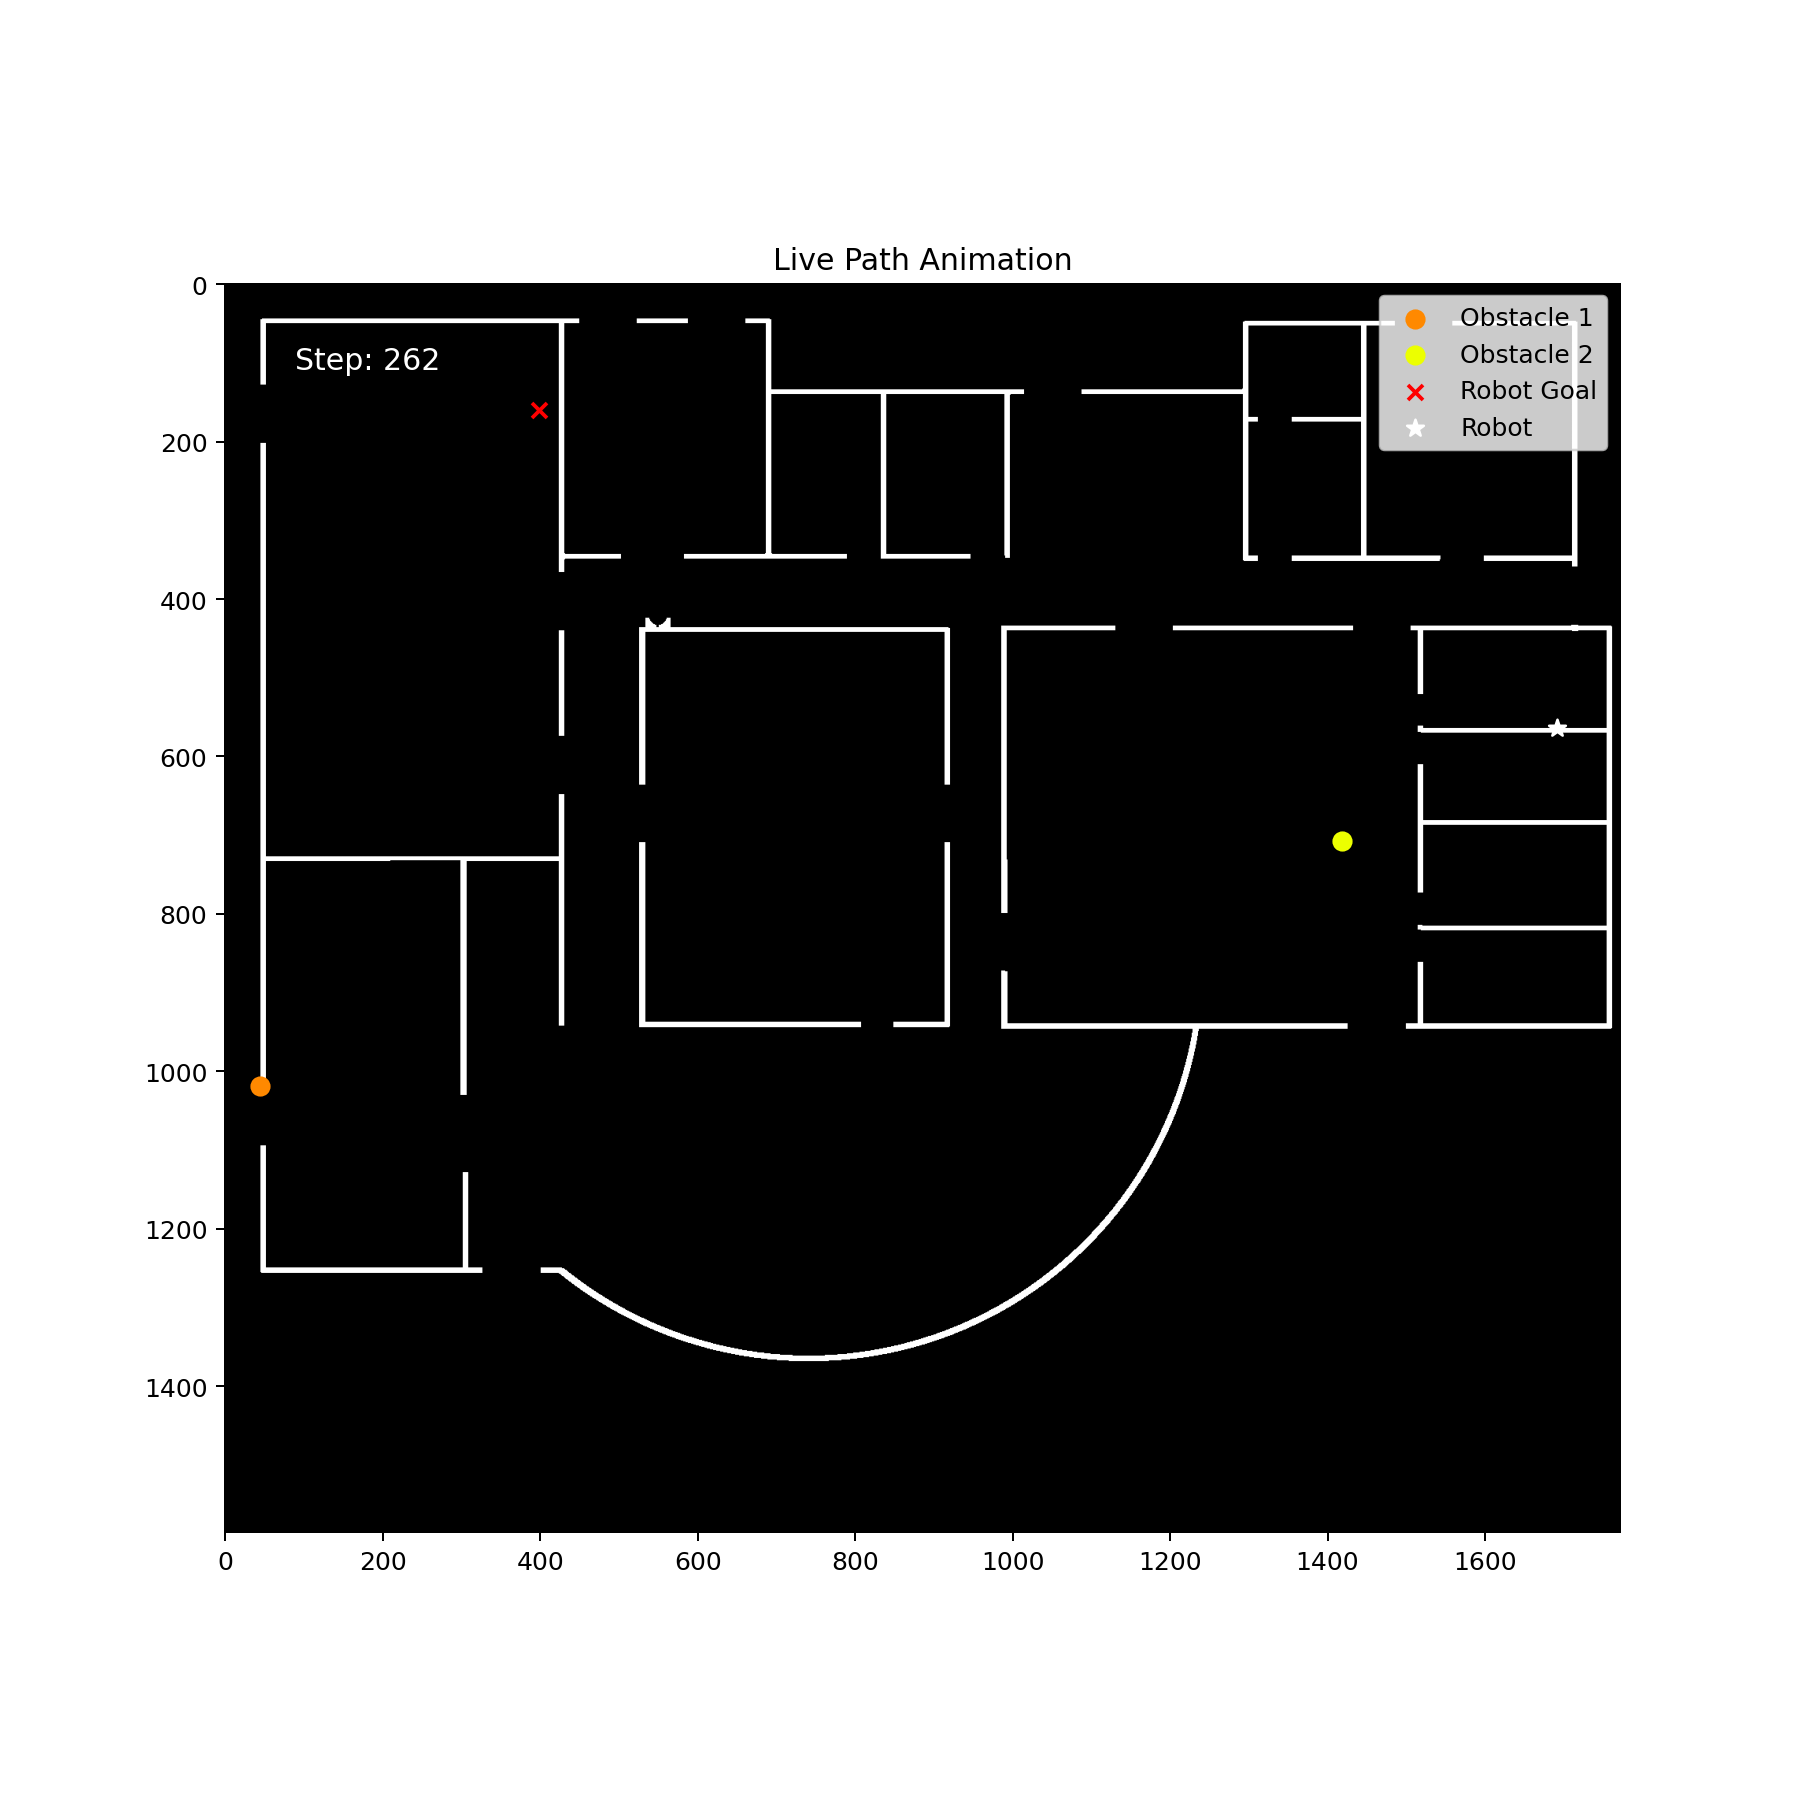

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_12211/1993421187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', num_colors + 10)


In [36]:
%matplotlib notebook


# Assuming gridworld, obstacle_paths, number_of_obstacles, episode_length, and robotPath are already defined

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for the robot's start and goal positions
robot_start = robotPath[0]
robot_goal = env.goal_position
# ax.scatter([robot_start[1]], [robot_start[0]], c='green', marker='^', label='Robot Start')
ax.scatter([robot_goal[1]], [robot_goal[0]], c='red', marker='x', label='Robot Goal')

# Initialize the scatter points for start and end of obstacles
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
#     ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
#     ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

# Initialize a scatter plot for the robot's current position
robot_scatter = ax.scatter([], [], color='white', s=50, marker='*', label='Robot')
scatters.append(robot_scatter)

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters, robot_path):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    
    if num < len(robot_path):
        scatters[-1].set_offsets([robot_path[num][1], robot_path[num][0]])
    
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())
max_path_length = max(max_path_length, len(robotPath))

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=max_path_length, fargs=[obstacle_paths, scatters, robotPath], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()